#importing

In [ ]:
import os
import string
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

import gensim 
import logging
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Functions



##pre-process

In [ ]:
from nltk.stem.porter import PorterStemmer

def tokenize(line, dix=None, stopwords=None, stem=False):
    line = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', line.lower().strip()) 
    tokens = line.split()
    #print(tokens)

    if dix:
        #tokens = [dix[word] if word in dix else word for word in tokens]
        temp = []
        for word in tokens:
            if word in dix:
                sublist = dix[word].split()
                for element in sublist:
                    temp.append(element)
            else:
                temp.append(word)
        tokens = temp

    if stopwords:
        tokens = [word for word in tokens if word not in stopwords]

    if stem:
      ps = PorterStemmer()
      tokens = [ps.stem(word) for word in tokens]
    
    #remove punctuations
    #translator = str.maketrans(dict.fromkeys(string.punctuation))
    #tokens = [word.translate(translator) for word in tokens]
    return tokens

In [ ]:
def vocab_to_dict(vocab, slangdix=None):
    dix1 = {}
    dix2 = {}
    if slangdix is None:
        slangs = []
    else:
      slangs = slangdix.keys()
    i = 0
    for word in vocab:
        if word not in dix1:
            if word in slangs:
                origin = slangdix[word]
                if origin in dix1:
                    dix1[word] = dix1[origin]
                    
                else:
                    dix1[word] = i
                    dix1[origin] = i
                    dix2[i] = origin
                    i += 1
            else:
                dix1[word] = i
                dix2[i] = word
                i += 1
    return dix1, dix2


# data

In [ ]:
names = ['label','ids','date','noquery','username','text']
train_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv', encoding = 'latin-1', names = names)

In [ ]:
train_data = train_data.drop('noquery', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
train_data.head(5)

In [ ]:
keep = ['just', 'too', 'very', 'no', 'not', 'nor', 'should']
stopwords = stopwords.words('english')
for word in keep:
  stopwords.remove(word)

In [ ]:
train_data['clean'] = train_data.apply(lambda x:  tokenize(x['text'], dix=None, stopwords=stopwords, stem=True), axis=1)

In [ ]:
train_data.head(5)

,label,ids,date,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
data = pd.read_excel('/content/gdrive/MyDrive/Colab Notebooks/practice.xlsx')

In [ ]:
data['clean'] = data.apply(lambda row: tokenize(line=row['text'], stopwords=stopwords, stem=True), axis=1)

##w2v

In [ ]:
all_sentences = []
for row in train_data['clean']:
    all_sentences.append(list(row))


In [ ]:
for row in data['clean']:
    all_sentences.append(list(row))

In [ ]:
model_0624122 = gensim.models.Word2Vec(sentences = all_sentences, min_count = 2,size = 100, window = 5, sg=0) 

In [ ]:
model_0624122.save("/content/gdrive/MyDrive/Colab Notebooks/praxis_twi140_min2_size100_window5.model")

##load

In [ ]:
from gensim.models import Word2Vec
model_0624122 = Word2Vec.load("/content/gdrive/MyDrive/Colab Notebooks/praxis_twi140_min2_size100_window5.model")

In [ ]:
def list_to_vec(tokens):
  matrix = []
  for word in tokens:
    if word in model_0624122:
      vec = model_0624122[word]
      matrix.append(vec)
  return matrix

In [ ]:
data['vectors'] = data['clean'].apply(list_to_vec)

In [ ]:
data.head()

In [ ]:
data.to_pickle('/content/gdrive/MyDrive/slgCsv/praxis_vec_0624.pickle')

In [ ]:
train_data['vectors'] = train_data['clean'].apply(list_to_vec)

In [ ]:
train_data.to_pickle('/content/gdrive/MyDrive/slgCsv/twi140_vec_0624.pickle')

In [ ]:
from IPython.display import Image
import graphviz
from graphviz import Digraph
from graphviz import Source

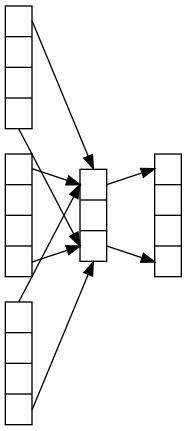

In [ ]:
cbow = '''digraph G {
  compound = true;
  splines = false;
	rankdir = LR
  subgraph claster1{
    label="input"
    in1 [shape=record, width=.1, height=.4, label="<f1>|<f2>|<f3>|<f4>"]
    in2 [shape=record, width=.1, height=.4, label="<f1>|<f2>|<f3>|<f4>"]
    in3 [shape=record, width=.1, height=.4, label="<f1>|<f2>|<f3>|<f4>"]
  }
  subgraph claster2{
    label="hidden"
    h [shape=record, width=.1, height=.3, label="<f1>|<f2>|<f3>"]
  }
  
  subgraph claster3{
    label="output"
    ot1 [shape=record, width=.1, height=.4, label="<f1>|<f2>|<f3>|<f4>"]
  }
  
  "in1":f1 -> "h":f1
  "in1":f4 -> "h":f3
  "in2":f1 -> "h":f1
  "in2":f4 -> "h":f3
  "in3":f1 -> "h":f1
  "in3":f4 -> "h":f3

  "h":f1 -> "ot1":f1
  "h":f3 -> "ot1":f4


}'''

dot = Source(cbow)

dot.format='png'
dot.render('neural_02', view=True)
Image('neural_02.png')

#rnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader 

import matplotlib.pyplot as plt
import tensorflow as tf

from IPython.display import display
from PIL import Image
import random
import pickle
import pathlib

In [ ]:
'''class TrainData(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    #self.transform = transform
    self.length = len(dataframe)
    vectors = self.dataframe['vectors']
    label = self.dataframe['label']

    self.vectors_train=torch.tensor(vectors,dtype=torch.float32)
    self.label_train=torch.tensor(label,dtype=torch.float32)
  def __len__(self):
    return self.length

  def __getitem__(self, index):

    #if self.transform: 
    #  vectors = self.transform(vectors)
    return self.vectors_train[index], self.label_train[index]
'''

In [ ]:
class TrainData(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.length = len(dataframe)

  def __len__(self):
    return self.length

  def __getitem__(self, index):
    vectors = self.dataframe['vectors'][index]
    label = self.dataframe['label'][index]
    if self.transform: 
      vectors = self.transform(vectors)
    return vectors, label

In [ ]:
class lstm(nn.Module):
  def __init__(self, dimension, hidden_size, layers, drop_rate=0.1):
      super(lstm, self).__init__()
      self.name = 'LSTM'
      self.rnn = nn.LSTM( # pytorch官方的LSTM
          input_size=dimension, # 输入特征数（词嵌入的维数
          hidden_size=hidden_size, # 隐藏层大小
          num_layers=layers, # 层数
          dropout=drop_rate, # （每个LSTM层）dropout率 以防过拟合
          )
      self.decoder = nn.Sequential(
          nn.Linear(hidden_size*2, hidden_size),
          #nn.ReLU(),
          nn.Linear(hidden_size, 2),
      )

      self.h_0 = None # initial hidden state
      self.c_0 = None # initial cell state

  def forward(self, x):
    out, (h_n, c_n) = self.rnn(x) #h_n, c_n: final hidden and cell states
    out = self.decoder(out)
    #out = self.decoder(torch.cat(out[0], out[-1]), dim=1)
    return out

In [ ]:
def evaluate(model, testloader): 
    error = 0
    length = 0
    for vectors, labels in testloader: 
        # pos和neg两种的话
        error += int(((model(vectors) > 0).squeeze() != labels).sum())       
        # pos neg neutral
        # error = 
        length += len(labels)
    print(error)
    return float(error) / length

## train

In [ ]:
#load training data from the pickle just written
data = pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/twi140_vec_0624.pickle')

In [ ]:
data

In [ ]:
# 不要运行多次
data['label'] = data['label'].apply(lambda x: int(x/2.0)-1)

In [ ]:
data

In [ ]:
# divide dataframe into training evaluating and testing, normalize labels
np_data = data.to_numpy()
print(type(np_data))
np.random.seed(1000)
np.random.shuffle(np_data)

<class 'numpy.ndarray'>


In [ ]:
data1 = np_data[:500]

In [ ]:
from sklearn.utils import shuffle
data1 = shuffle(data)

In [ ]:
data1 = data1[:500]

In [ ]:
data1.to_pickle('/content/gdrive/MyDrive/twi140_vec_first500_0629.pickle')

In [ ]:
data1 = data1.reset_index(drop=True)

In [ ]:
data1

In [ ]:
# 用前500试一下
train_data = np_data[:400]
val_data = np_data[400:450]
test_data = np_data[450:500]

In [ ]:
def train(size_in, hidden_size, layers, drop=0.1, bs=32, lr=0.001, num_epochs = 10):    
    model = lstm(size_in, hidden_size, layers, drop)
    torch.manual_seed(1000)

    train_dataset = TrainData(train_data, transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_dataset = TrainData(val_data, transform=transforms.ToTensor())
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = pathlib.Path(f"/content/drive/MyDrive/APS360/Models/malaria_corrected_bs{bs}_lr{lr}")
    model_path.mkdir(parents=True, exist_ok=True)
    # model.cuda()

    train_loss = np.zeros(num_epochs)
    val_error = np.zeros(num_epochs)
    n = len(train_loader)

    for epoch in range(num_epochs):
        epoch_loss = 0 
        for vectors, labels in train_loader: 
            labels = labels.unsqueeze(1).float()
            outputs = model(vectors)
            #loss_value = loss(outputs, labels)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss[epoch] = epoch_loss / n
        val_error[epoch] = evaluate(model, val_loader)
        #print validation error
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}, Validation Error: {val_error[epoch]:.6f}")

        torch.save(model.state_dict(), model_path / f"epoch_{epoch+1}")

    return model_path

In [ ]:
train(100, 20, 2)